In [49]:
import math

from skimage import data
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
plt.gray()

from numba import jit
import numba
%matplotlib inline

# Blurring
Blurring is an important area in image processing, because it reduces noise. In general, if you have some noise, taking the mean of that noise will reduce the variance. In the same way, taking the mean of a patch of an image will reduce the variance of that patch. The problem is that when doing this, information is lost about the content of the image, which results in a "blur". Linear blurs are typically convolutions, where we denote the image $I$ convolved with a filter $k$ as $I*k$. This operation corresponds to taking each continguous patch of $I$ of the same size as $k$ and summing their pointwise product. On the boundaries, one can consider any value beyond the boundary to be zero, or we can let the boundary be a symmetric flip of the image over it. I use the second approach here. In the implementation, we can note that if $k$ has rank 1, we can factor $k = u v^T$, so we can take $(I*u)*v^T$ instead of $I*k$ with the same result, but much less computational cost.

Taking the mean here corresponds to a box filter, which averages a square section of pixels in the image. This might not be an optimal metric, as it weights faraway pixels the same as those near the pixel of interest. For this reason, Gaussian kernels are often used. They assign high weight to the pixels neighboring the pixel of interest, and smoothly fall off as it gets further away. Theoretically, they also have very nice properties, so they tend to be a popular choice. Both of these methods, however, are somewhat outlier-sensitive, meaning that if there are a few major outliers, they might still pass noise through. This can be alleviated by increasing the variance or radius of the filter, making it an average over more pixels, but that results in more loss of information. A solution to that is using a median filter, which takes the median of pixels in each patch. This is a nonlinear operation, so it is not as nice mathematically to work with, but it is more resistant to outliers.

A box filter has a kernel that is uniformly one, normalized by its sum, while a Gaussian filter has a kernel where if we index $x$ and $y$ $-k$ to $k$, then $k_{x,y} \propto \exp((x^2+y^2)/2\sigma^2)$, and it is normalized to sum to 1

## Experiments 
To experiment here, I first run all filters at different sizes on the same images, and then I add noise to the images at different levels, to see how the results are affected by noise. For conciseness, I will only use the cameraman as a test image with noise, but without noise I show all three, as it is interesting to see the differences on different images. In addition, I only use Gaussian noise, but I could also use some other noise pattern.

We can see that each noise level, the Gaussian blur seems to be at least as good as the box filter, while the bilinear filter is not particularly effective at high noise levels. This is to be expected, as it is very small. The Gaussian filter seems to preserve the general form of the image better than a box filter, while the median filter preserves the general colors of the image beter. The RMSE between the ground truth image and blurred image is printed in each subplot title, and we can see that at low noise levels, bilinear interpolation performs better than other methods with small filter sizes, but as the noise increases, it performs relatively worse. Confirming what appears from visual inspection, the Gaussian filter is more effective at retaining detail and removing noise than other methods. In addition, if it is more critical to remove all noise rather than retain all features, although the larger filters result in a greater difference RMSE, a Gaussian filter does achieve a lower error at the levels of higher blurring as well.

In [78]:
@jit(numba.float32[:, :](numba.float32[:, :], numba.float32[:], numba.float32[:]))
def corr_sep(im, h, v):
    # Convolution with separable kernel (k=h v^T) of odd dimensions
    # I am assuming symmetric boundary conditions (consistent with boundary='symm'
    # in scipy.signal.convolve2d)
    tmp = np.zeros_like(im)
    out = np.zeros_like(im)
    n_prev_v = len(v)/2.0
    n_prev_h = len(h)/2.0
    
    # Vertical conv first, save in tmp
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):        
            for ix, k in enumerate(range(i-math.floor(n_prev_v), i+math.ceil(n_prev_v))):
                if k < len(im):
                    tmp[i, j] += im[abs(k)-(k<0), j] * v[ix]
                else:
                    tmp[i, j] += im[len(im)-k-1, j] * v[ix]

    # Horiziontal next, save in out
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            for ix, k in enumerate(range(j-math.floor(n_prev_h), j+math.ceil(n_prev_h))):
                if k < len(im[0]):
                    out[i][j] += tmp[i][abs(k)-(k<0)] * h[ix] # double count edge
                else:
                    out[i][j] += tmp[i][len(im[0])-k-1] * h[ix]
    return np.array(out, dtype=np.float32)

@jit
def medfilt(im, size):
    # apply f to each patch of image, patch is variable size
    if type(size) == int:
        size = (size, size)
    im = np.array(im)
    out = np.zeros((len(im), len(im[0])))
    n_prev_v = size[0]
    n_prev_h = size[1]
    
    mh = out.shape[0]-1
    mw = out.shape[1]-1
    
    # Apply function to each patch
    for i in range(out.shape[0]):
        for j in range(out.shape[1]): 
            s = np.s_[max(i-n_prev_v, 0):min(i+n_prev_v+1, mh), max(j-n_prev_h, 0):min(j+n_prev_h+1, mw)]
            out[i,j] = np.median(im[s])
    return np.array(out, dtype=np.float32)

def blur_gaussian(im, variance, radius=None):
    radius = radius or np.ceil(3*np.sqrt(variance))
    k = np.exp(-np.arange(-radius, radius+1)**2 / (2*variance)).astype(np.float32)
    k /= k.sum()
    return corr_sep(im.astype(np.float32), k, k)
def blur_box(im, radius):
    k = np.ones(2*radius+1)*1.0
    k /= k.sum()
    return corr_sep(im.astype(np.float32), k.astype(np.float32), k.astype(np.float32))
def blur_bilinear(im):
    k = np.array([1.0, 2, 1])/ 4.0
    return corr_sep(im.astype(np.float32), k.astype(np.float32), k.astype(np.float32))
def get_images():
    return [data.text(), data.camera(), data.coins()], ['Text', 'Cameraman', 'Coins']

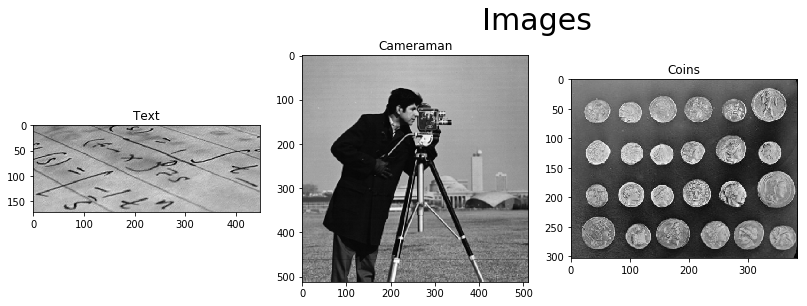

In [68]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('Images', fontsize=30)

ims, nms = get_images()
for i in range(len(ims)):
    ax = fig.add_subplot(len(ims),len(rs),i+1)
    ax.imshow(ims[i])
    ax.set_title(nms[i])


fig.set_facecolor('w')
plt.tight_layout()
plt.show()


## Blurring filters with no noise added

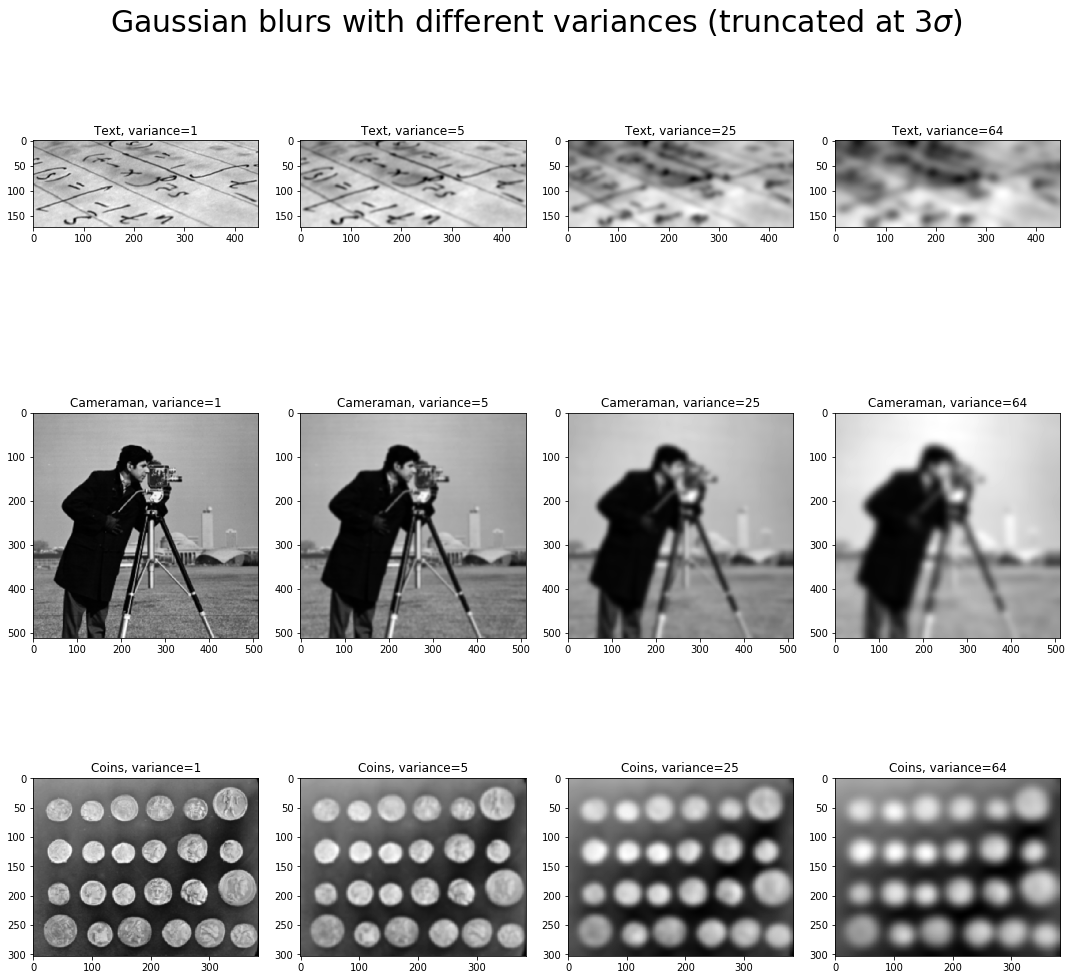

In [73]:
# Gaussian different sigma
fig = plt.figure(figsize=(15,15))
fig.suptitle('Gaussian blurs with different variances (truncated at $3\sigma$)', fontsize=30)

ims, nms = get_images()
rs = [1, 5, 25, 64]
ct = 0
for i in range(len(ims)):
    for j in range(len(rs)):
        ct += 1
        ax = fig.add_subplot(len(ims),len(rs),ct)
        b = blur_gaussian(ims[i], rs[j])
        ax.imshow(b)
        ax.set_title('%s, variance=%d'%(nms[i], rs[j]))


fig.set_facecolor('w')
plt.tight_layout()

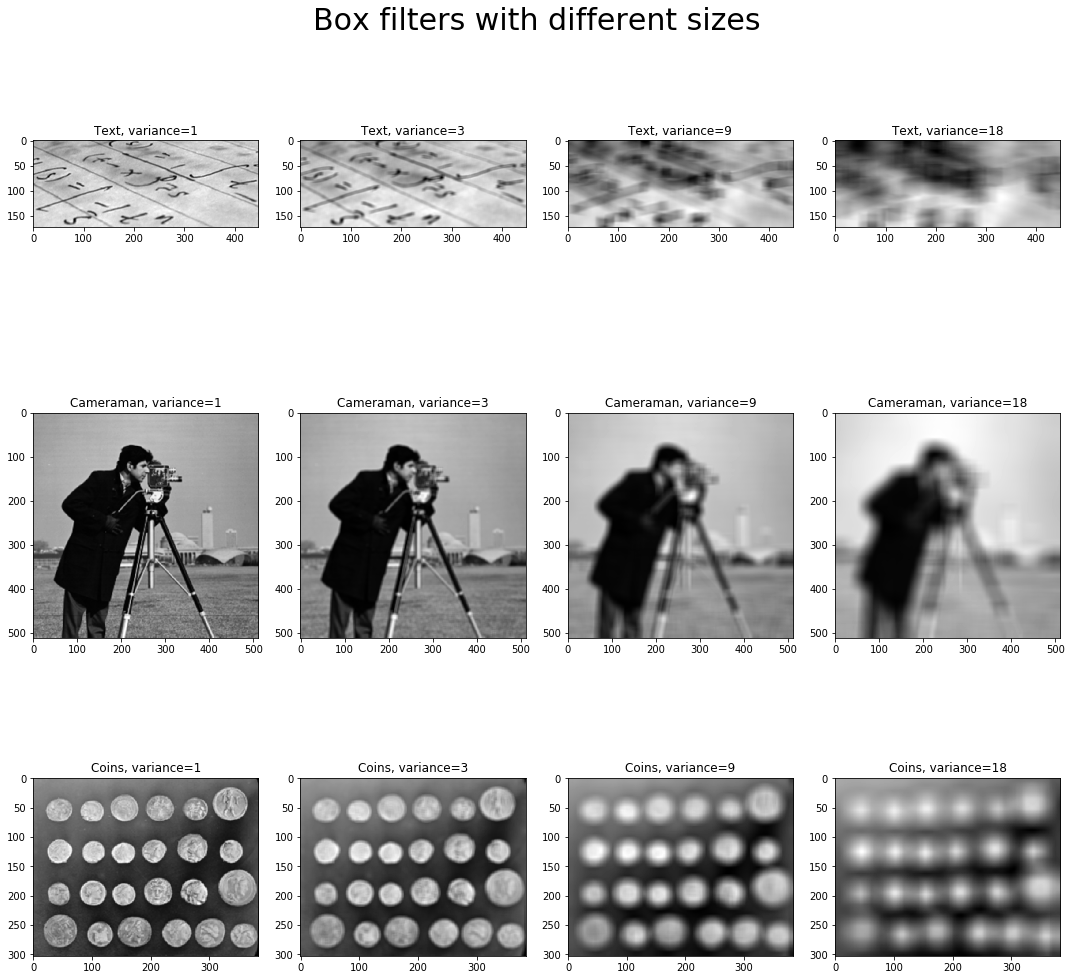

In [74]:
# Box Filters
fig = plt.figure(figsize=(15,15))
fig.suptitle('Box filters with different sizes', fontsize=30)

ims, nms = get_images()
rs = [1, 3, 9, 18]
ct = 0
for i in range(len(ims)):
    for j in range(len(rs)):
        ct += 1
        ax = fig.add_subplot(len(ims),len(rs),ct)
        b = blur_box(ims[i], rs[j])
        ax.imshow(b)
        ax.set_title('%s, variance=%d'%(nms[i], rs[j]))


fig.set_facecolor('w')
plt.tight_layout()

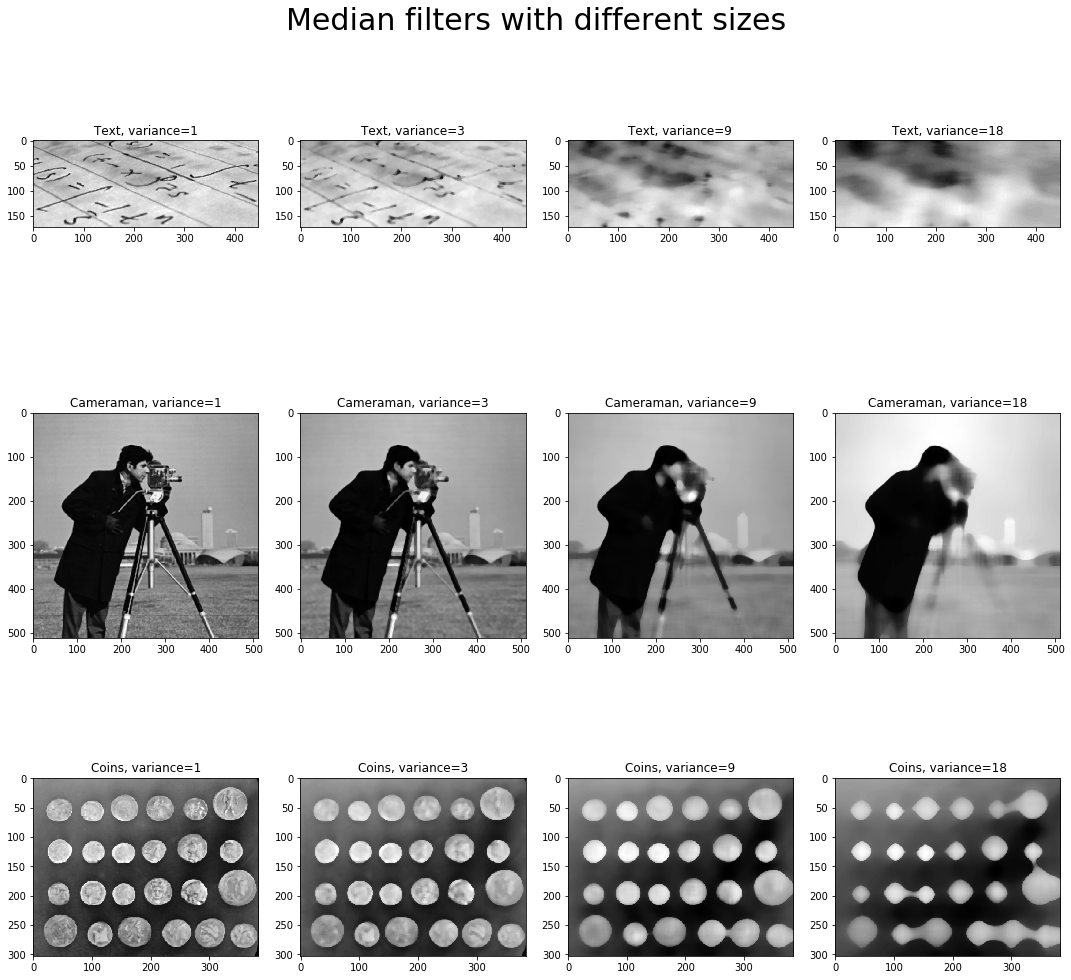

In [81]:
# Box Filters
fig = plt.figure(figsize=(15,15))
fig.suptitle('Median filters with different sizes', fontsize=30)

ims, nms = get_images()
rs = [1, 3, 9, 18]
ct = 0
for i in range(len(ims)):
    for j in range(len(rs)):
        ct += 1
        ax = fig.add_subplot(len(ims),len(rs),ct)
        b = medfilt(ims[i], rs[j])
        ax.imshow(b)
        ax.set_title('%s, variance=%d'%(nms[i], rs[j]))


fig.set_facecolor('w')
plt.tight_layout()

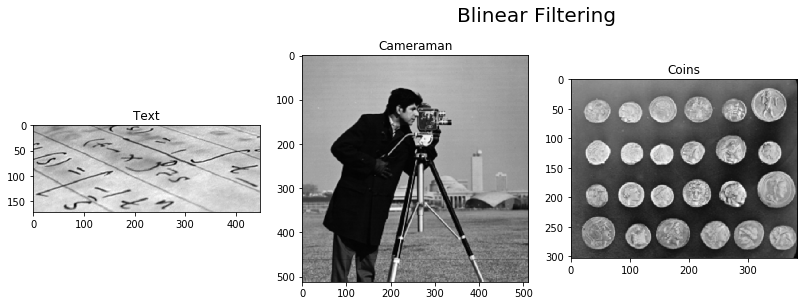

In [75]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('Blinear Filtering', fontsize=20)

ims, nms = get_images()
for i in range(len(ims)):
    ax = fig.add_subplot(len(ims),len(rs),i+1)
    ax.imshow(blur_bilinear(ims[i]))
    ax.set_title(nms[i])


fig.set_facecolor('w')
plt.tight_layout()

In [82]:
im = data.camera()

In [85]:
def noisify(im, sigma):
    return np.clip(im +np.random.randn(*im.shape)*sigma, im.min(), im.max())

## Gaussian blurs of noisy image

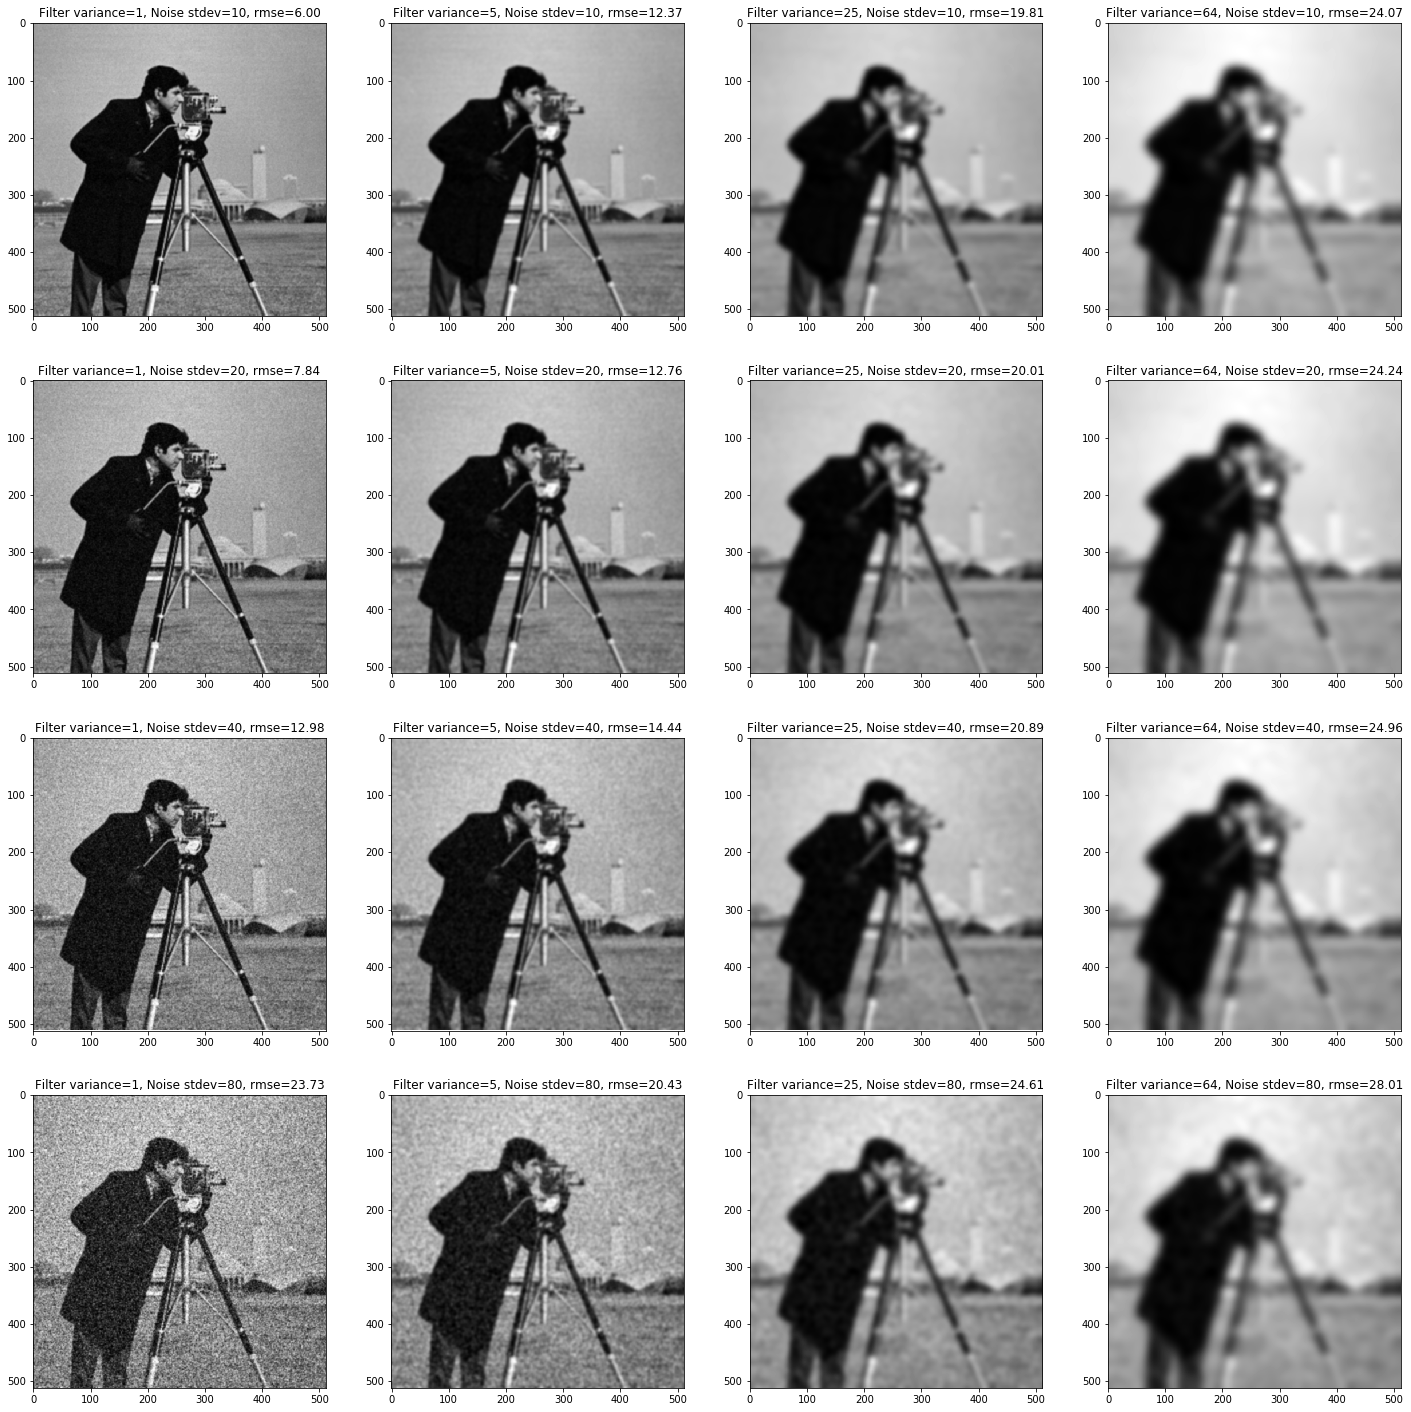

In [106]:
# Gaussian different sigma
fig = plt.figure(figsize=(20,20))

rs = [1, 5, 25, 64]
noise_sigmas = [10, 20, 40, 80]
ct = 0

for i in range(len(noise_sigmas)):
    for j in range(len(rs)):
        np.random.seed(19981501)
        ct += 1
        ax = fig.add_subplot(len(noise_sigmas),len(rs),ct)
        b = blur_gaussian(noisify(im, noise_sigmas[i]), rs[j])
        ax.imshow(b)
        ax.set_title('Filter variance=%d, Noise stdev=%d, rmse=%.2f'%(rs[j], noise_sigmas[i], np.sqrt(((b-im)**2).mean())))


fig.set_facecolor('w')
plt.tight_layout()

## Box blurs of noisy image

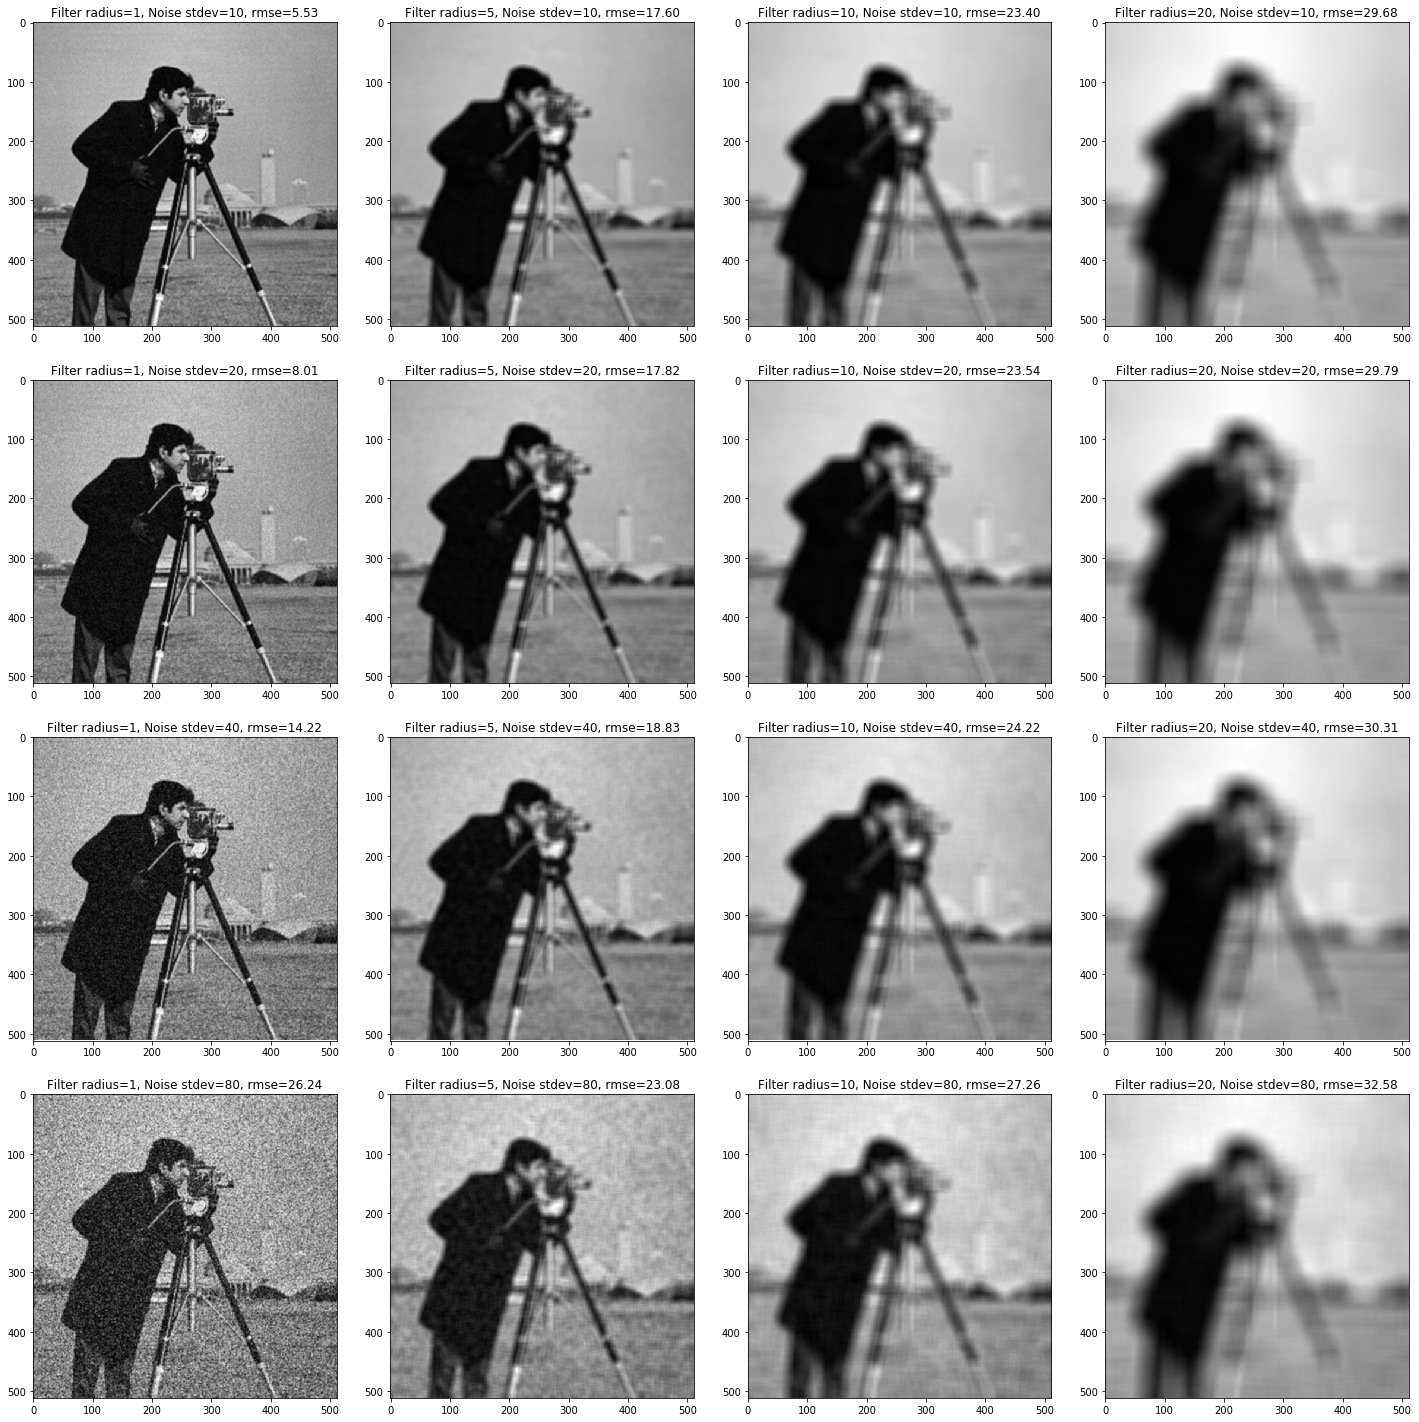

In [105]:
# Gaussian different sigma
fig = plt.figure(figsize=(20,20))

rs = [1, 5, 10, 20]
noise_sigmas = [10, 20, 40, 80]
ct = 0

for i in range(len(noise_sigmas)):
    for j in range(len(rs)):
        np.random.seed(19981501)
        ct += 1
        ax = fig.add_subplot(len(noise_sigmas),len(rs),ct)
        b = blur_box(noisify(im, noise_sigmas[i]), rs[j])
        ax.imshow(b)
        ax.set_title('Filter radius=%d, Noise stdev=%d, rmse=%.2f'%(rs[j], noise_sigmas[i], np.sqrt(((b-im)**2).mean())))


fig.set_facecolor('w')
plt.tight_layout()

## Median filters of noisy image

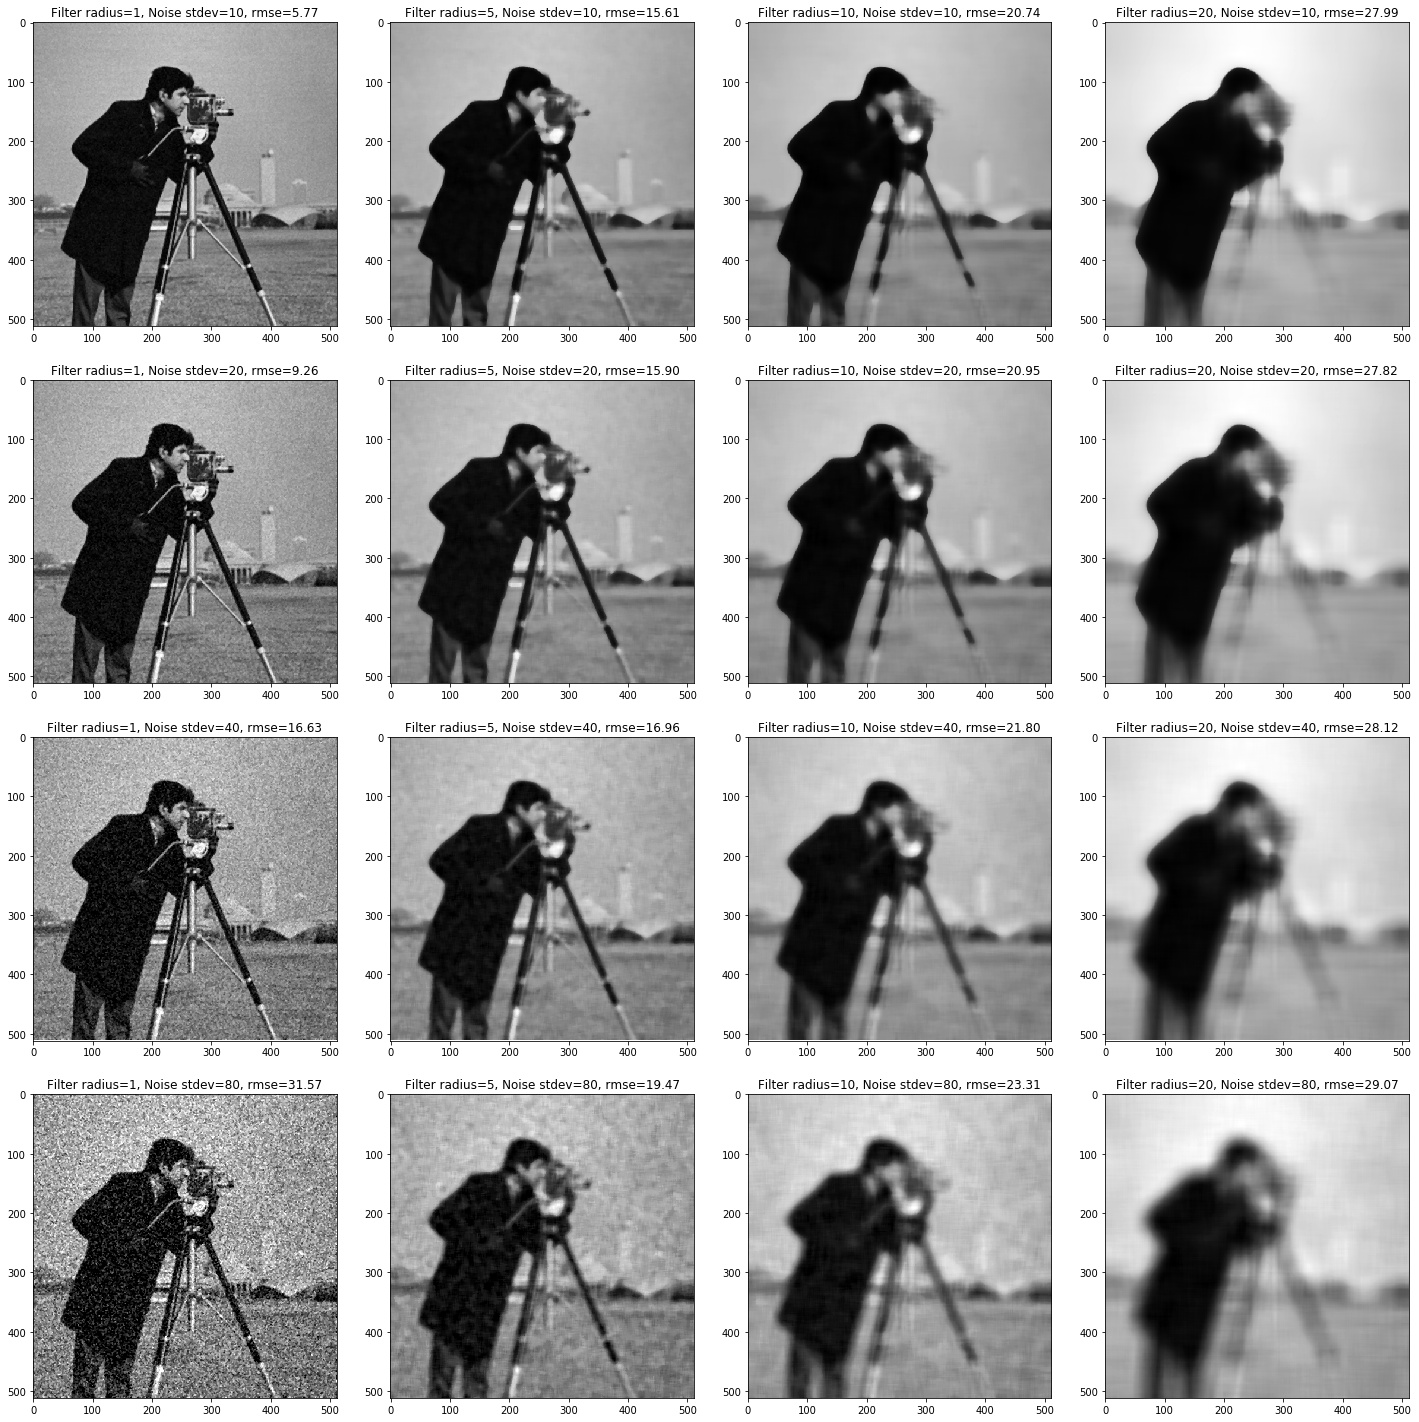

In [104]:
# Gaussian different sigma
fig = plt.figure(figsize=(20,20))

rs = [1, 5, 10, 20]
noise_sigmas = [10, 20, 40, 80]
ct = 0

for i in range(len(noise_sigmas)):
    for j in range(len(rs)):
        np.random.seed(19981501)
        ct += 1
        ax = fig.add_subplot(len(noise_sigmas),len(rs),ct)
        b = medfilt(noisify(im, noise_sigmas[i]), rs[j])
        ax.imshow(b)
        ax.set_title('Filter radius=%d, Noise stdev=%d, rmse=%.2f'%(rs[j], noise_sigmas[i], np.sqrt(((b-im)**2).mean())))

fig.set_facecolor('w')
plt.tight_layout()

## Bilinear filters of noisy image

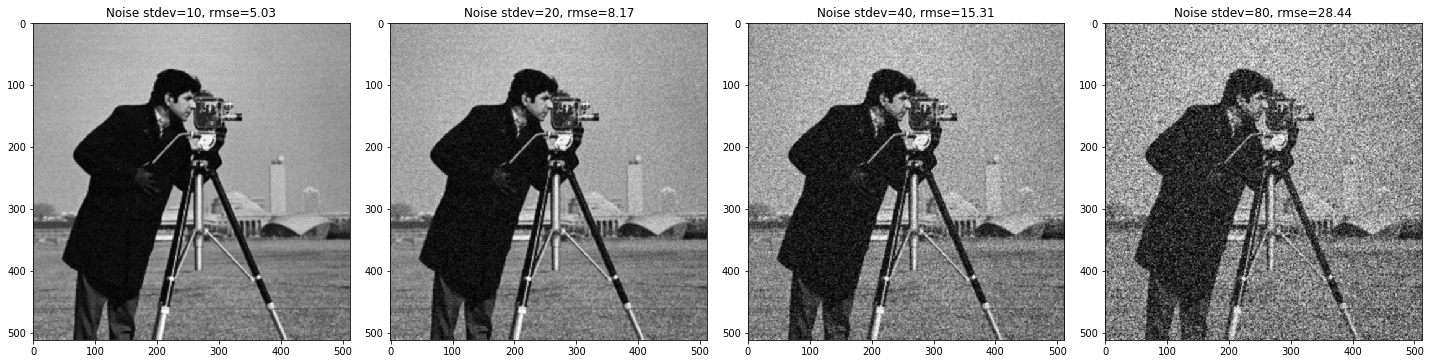

In [108]:
# Gaussian different sigma
fig = plt.figure(figsize=(20,20))

noise_sigmas = [10, 20, 40, 80]
ct = 0

for i in range(len(noise_sigmas)):
    np.random.seed(19981501)
    ct += 1
    ax = fig.add_subplot(1, len(noise_sigmas),ct)
    b = blur_bilinear(noisify(im, noise_sigmas[i]))
    ax.imshow(b)
    ax.set_title('Noise stdev=%d, rmse=%.2f'%(noise_sigmas[i], np.sqrt(((b-im)**2).mean())))


fig.set_facecolor('w')
plt.tight_layout()